In [214]:
import csv
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings("ignore")


In [215]:
citydailydata = pd.read_csv('./input/city_day.csv')

# 1. Exploring the data

In [216]:
def getArray(csvfile):
    city_daily_data = np.empty((0,16))
    for row in dailydata:
        city_daily_data = np.vstack((city_daily_data, np.array(row)))
    return city_daily_data

In [217]:
def getCities(data):
    cities = data['City'].value_counts()
    print('\nCITIES COVERED IN THE DATA:')
    print('Total number of cities in the dataset :', len(cities))
    names = cities.index
    print('Cities: ', ', '.join(names),'\n')

In [218]:
def getDurationOfData(data):
    print('DURATION OF DATA: \nThe data is between', data['Date'].min(), 'and' , data['Date'].max(),'\n')

In [219]:
def exploreData(data):
    getCities(data)
    getDurationOfData(data)

In [220]:
exploreData(citydailydata)


CITIES COVERED IN THE DATA:
Total number of cities in the dataset : 26
Cities:  Mumbai, Chennai, Delhi, Ahmedabad, Lucknow, Bengaluru, Hyderabad, Patna, Gurugram, Visakhapatnam, Amritsar, Jorapokhar, Jaipur, Thiruvananthapuram, Amaravati, Brajrajnagar, Talcher, Kolkata, Guwahati, Coimbatore, Shillong, Chandigarh, Bhopal, Kochi, Ernakulam, Aizawl 

DURATION OF DATA: 
The data is between 2015-01-01 and 2020-07-01 



# 2. Handling Missing Values

In [221]:
def getMissingValues(data):
    missing_val = data.isnull().sum()
    missing_val_percentage = 100 * data.isnull().sum() / len(data)
    missin_values_array = pd.concat([missing_val, missing_val_percentage], axis=1)
    missin_values_array = missin_values_array.rename(columns = 
                                                     {0 : 'Missing Values', 1 : '% of Total Values'})
    missin_values_array = missin_values_array[
        missin_values_array.iloc[:,1] != 0].sort_values('% of Total Values', ascending=False).round(1)
    print('MISSING VALUES IN DATA:\n', missin_values_array, '\n')
    return missin_values_array

In [222]:
def mergeColumns(data):
    data['Date'] = pd.to_datetime(data['Date'])
    data['BTX'] = data['Benzene'] + data['Toluene'] + data['Xylene']
    data.drop(['Benzene','Toluene','Xylene'], axis=1)
    data['Particulate_Matter'] = data['PM2.5'] + data['PM10']
    return data

In [223]:
def subsetColumns(data):
    pollutants = ['Particulate_Matter', 'NO2', 'CO','SO2', 'O3', 'BTX']
    return pollutants

In [224]:
def handleMissingValues(data):
    missing_values = getMissingValues(data)
    updatedCityData = mergeColumns(data)
    newColumns = subsetColumns(data)
    return updatedCityData, newColumns

In [225]:
updatedCityData, newColumns = handleMissingValues(citydailydata)

MISSING VALUES IN DATA:
             Missing Values  % of Total Values
Xylene               18109               61.3
PM10                 11140               37.7
NH3                  10328               35.0
Toluene               8041               27.2
Benzene               5623               19.0
AQI                   4681               15.9
AQI_Bucket            4681               15.9
PM2.5                 4598               15.6
NOx                   4185               14.2
O3                    4022               13.6
SO2                   3854               13.1
NO2                   3585               12.1
NO                    3582               12.1
CO                    2059                7.0 



# 3. Visualising data

In [226]:
def visualiseYearlyData(data, columns):    
    data.set_index('Date',inplace=True)
    axes = data[columns].plot(marker='.', alpha=0.5, linestyle='None', figsize=(16, 20), subplots=True)
    for ax in axes:
        ax.set_xlabel('Years')
        ax.set_ylabel('ug/m3')

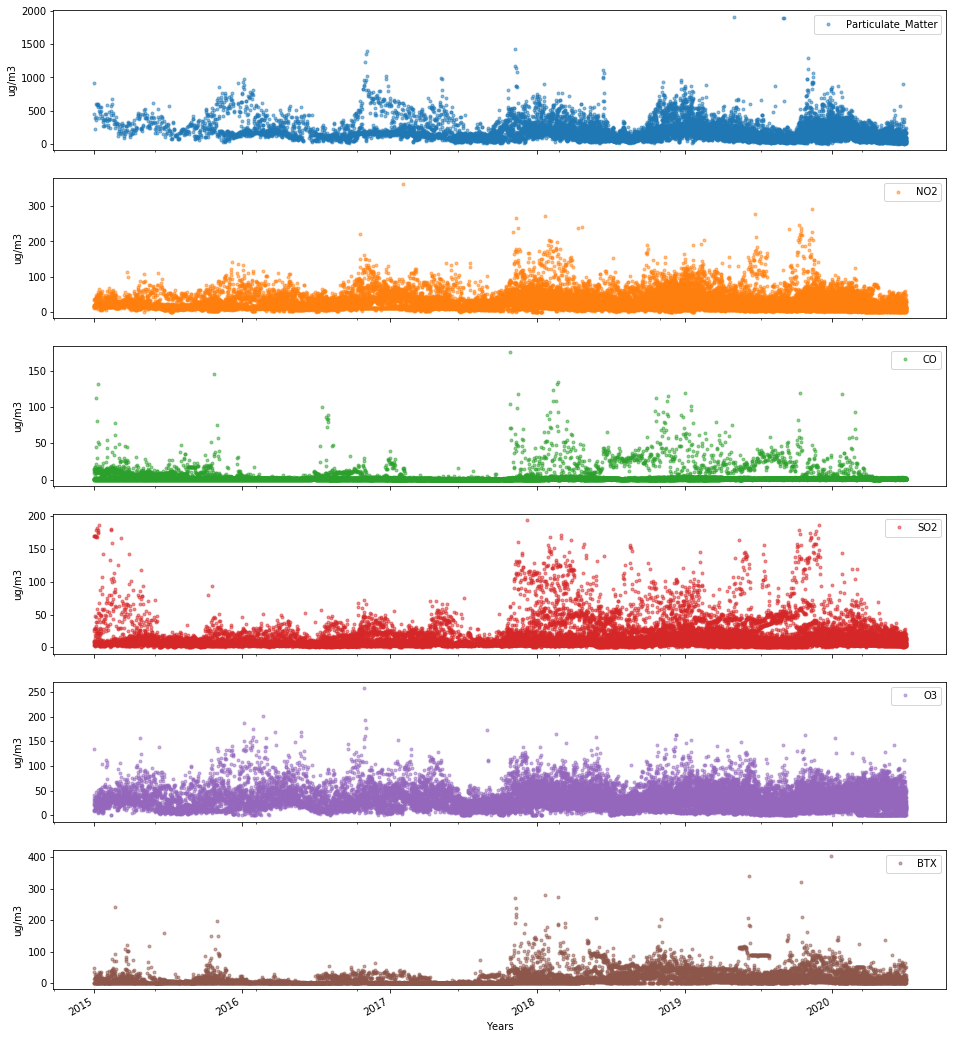

In [227]:
visualiseYearlyData(updatedCityData, newColumns)

In [228]:
def trend_plot(df, value):
    df['year'] = [d.year for d in df.Date]
    df['month'] = [d.strftime('%b') for d in df.Date]
    years = df['year'].unique()

    # Draw Plot
#     fig, axes = plt.subplots(1, 2, figsize=(14,6), dpi= 80)
    df.plot(x='year', y=value, kind='line')
#     sns.pointplot(x='month', y=value, data=df.loc[~df.year.isin([2015, 2020]), :])
    # Set Title
#     axes[0].set_title('Year-wise Box Plot \n(The Trend)', fontsize=18); 
#     axes[1].set_title('Month-wise Plot \n(The Seasonality)', fontsize=18)
    plt.show()

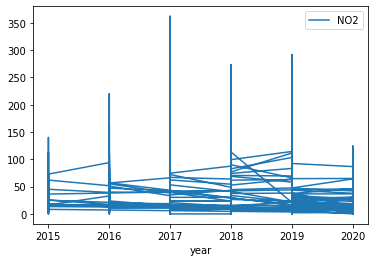

In [229]:
updatedCityData.reset_index(inplace=True)
df = updatedCityData.copy()
value='NO2'
trend_plot(df,value)

## 4. Effect of Lockdown on AQI


### A brief introduction to the calculation of AQI

<img style="float: center;" src="https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcR8MwkjROMGpNIVRTeKgO_vIj2QU-J9MAIW8v6wf6yg6mWvPPWH&usqp=CAU.jpg">

1. The AQI calculation uses 7 measures: PM2.5(Particulate Matter 2.5-micrometer), PM10, SO2, NOx, NH3, CO and O3(ozone).

2. For PM2.5, PM10, SO2, NOx and NH3 the average value in last 24-hrs is used with the condition of having at least 16 values.

3. For CO and O3 the maximum value in last 8-hrs is used.

4. Each measure is converted into a Sub-Index based on pre-defined groups.

5. Sometimes measures are not available due to lack of measuring or lack of required data points.

6. Final AQI is the maximum Sub-Index with the condition that at least one of PM2 and PM10 should be available and at least three out of the seven should be available.

### How is AQI calculated?
1. The Sub-indices for individual pollutants at a monitoring location are calculated using its
24-hourly average concentration value (8-hourly in case of CO and O3) and health
breakpoint concentration range. The worst sub-index is the AQI for that location.
2. All the eight pollutants may not be monitored at all the locations. Overall AQI is
calculated only if data are available for minimum three pollutants out of which one should
necessarily be either PM2.5 or PM10. Else, data are considered insufficient for calculating
AQI. Similarly, a minimum of 16 hours’ data is considered necessary for calculating subindex.
3. The sub-indices for monitored pollutants are calculated and disseminated, even if data are
inadequate for determining AQI. The Individual pollutant-wise sub-index will provide air
quality status for that pollutant.
4. The web-based system is designed to provide AQI on real time basis. It is an automated
system that captures data from continuous monitoring stations without human
intervention, and displays AQI based on running average values (e.g. AQI at 6am on a
day will incorporate data from 6am on previous day to the current day).
5. For manual monitoring stations, an AQI calculator is developed wherein data can be fed
manually to get AQI value. 

Let us take a look at the ranges of AQI.

<img src="https://i.imgur.com/XmnE0rT.png" alt="">



In [230]:
cities = ['Ahmedabad','Delhi','Bengaluru','Mumbai','Hyderabad','Chennai']

filtered_city_day = df[df['Date'] >= '2019-01-01']
AQI = filtered_city_day[filtered_city_day.City.isin(cities)][['Date','City','AQI','AQI_Bucket']]

AQI.head()

,Date,City,AQI,AQI_Bucket
1461,2019-01-01,Ahmedabad,1474.0,Severe
1462,2019-01-02,Ahmedabad,1246.0,Severe
1463,2019-01-03,Ahmedabad,1719.0,Severe
1464,2019-01-04,Ahmedabad,1264.0,Severe
1465,2019-01-05,Ahmedabad,1127.0,Severe


In [231]:
AQI_pivot = AQI.pivot(index='Date', columns='City', values='AQI')
AQI_pivot.fillna(method='bfill',inplace=True)


from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(
    rows=6, cols=1,
    #specs=[[{}, {}],
          # [{"colspan": 6}, None]],
    subplot_titles=("Ahmedabad","Bengaluru","Chennai","Delhi",'Hyderabad','Mumbai'))

fig.add_trace(go.Bar(x=AQI_pivot.index, y=AQI_pivot['Ahmedabad'],
                    marker=dict(color=AQI_pivot['Ahmedabad'],coloraxis="coloraxis")),
              1, 1)
fig.add_trace(go.Bar(x=AQI_pivot.index, y=AQI_pivot['Bengaluru'],
                    marker=dict(color=AQI_pivot['Bengaluru'], coloraxis="coloraxis")),
              2, 1)
fig.add_trace(go.Bar(x=AQI_pivot.index, y=AQI_pivot['Chennai'],
                    marker=dict(color=AQI_pivot['Chennai'], coloraxis="coloraxis")),
              3, 1)
fig.add_trace(go.Bar(x=AQI_pivot.index, y=AQI_pivot['Delhi'],
                    marker=dict(color=AQI_pivot['Delhi'], coloraxis="coloraxis")),
              4, 1)
fig.add_trace(go.Bar(x=AQI_pivot.index, y=AQI_pivot['Hyderabad'],
                    marker=dict(color=AQI_pivot['Hyderabad'], coloraxis="coloraxis")),
              5, 1)
fig.add_trace(go.Bar(x=AQI_pivot.index, y=AQI_pivot['Mumbai'],  
                    marker=dict(color=AQI_pivot['Mumbai'], coloraxis="coloraxis")),
              6, 1)

fig.update_layout(coloraxis=dict(colorscale='Temps'),showlegend=False,title_text="AQI Levels")

fig.update_layout(plot_bgcolor='white')

fig.update_layout( width=800,height=1200,shapes=[
      dict(
      type= 'line',
      yref= 'paper', y0= 0, y1= 1,
      xref= 'x', x0= '2020-03-25', x1= '2020-03-25'
    )
])

fig.show()

> ** 📌 Points to note :** 
> * The black vertical line shows the date on which the first phase of lockdown ame into effect in India.
> * The above graph shows the variation of various pollutant levels, from Jan 2019 onwards till date.
> * Apparantely, all the above Indian cities seem to be a dangerously high level of pollution levels.
> * Clearly, there appears to be a rapid decline after 25th March,2020 in all the cities under sonsideration.

## <a> 4.4 AQI before and after Lockdown </a>

It'll be also interesting to see tha difference in AQI before and after the Lockdown.

In [232]:
AQI_beforeLockdown = AQI_pivot['2020-01-01':'2020-03-25']
AQI_afterLockdown = AQI_pivot['2020-03-26':'2020-05-01']

In [233]:
temp = df[df['Date']>="2020-01-20"]

temp = temp.groupby(['Date'])[['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2',
       'O3', 'Benzene', 'Toluene', 'Xylene',"AQI"]].median().reset_index()
fig = go.Figure()

fig.add_trace(go.Scatter(x=temp["Date"],y=temp["PM2.5"],
                        mode='lines+markers',name="PM2.5"))
fig.add_trace(go.Scatter(x=temp["Date"],y=temp["PM10"],
                        mode='lines+markers',name="PM10"))
fig.update_layout(shapes=[
    dict(
      type= 'line',
      yref= 'paper', y0= 0, y1= 1,
      xref= 'x', x0= '2020-03-25', x1= '2020-03-25'
    )
])
fig.update_layout(title={'text':'Change in PM2.5 and PM10 after 25th March'})
fig.update_xaxes(rangeslider_visible=True)
fig.show()

#Nitrogen Oxides
fig = go.Figure()

fig.add_trace(go.Scatter(x=temp["Date"],y=temp["NO"],
                        mode='lines+markers',name="NO"))
fig.add_trace(go.Scatter(x=temp["Date"],y=temp["NO2"],
                        mode='lines+markers',name="NO2"))
fig.add_trace(go.Scatter(x=temp["Date"],y=temp["NOx"],
                        mode='lines+markers',name="NOx"))
fig.update_layout(shapes=[
    dict(
      type= 'line',
      yref= 'paper', y0= 0, y1= 1,
      xref= 'x', x0= '2020-03-25', x1= '2020-03-25'
    )
])
fig.update_layout(title={'text':'Change in nitrogne oxides levels after 25th March'})
fig.update_xaxes(rangeslider_visible=True)
fig.show()

#Ammonia,Carbon Monoxide and Sulphur Dioxide and Ozone
fig = go.Figure()

fig.add_trace(go.Scatter(x=temp["Date"],y=temp["NH3"],
                        mode='lines+markers',name="NH3"))
fig.add_trace(go.Scatter(x=temp["Date"],y=temp["CO"],
                        mode='lines+markers',name="CO"))
fig.add_trace(go.Scatter(x=temp["Date"],y=temp["SO2"],
                        mode='lines+markers',name="SO2"))
fig.add_trace(go.Scatter(x=temp["Date"],y=temp["O3"],
                        mode='lines+markers',name="O3"))
fig.update_layout(shapes=[
    dict(
      type= 'line',
      yref= 'paper', y0= 0, y1= 1,
      xref= 'x', x0= '2020-03-25', x1= '2020-03-25'
    )
])
fig.update_layout(title={'text':'Change in NH3,CO,SO2,O3 levels after 25th March'})
fig.update_xaxes(rangeslider_visible=True)
fig.show()

#Benzene,Toluene,Xylene
fig = go.Figure()

fig.add_trace(go.Scatter(x=temp["Date"],y=temp["Benzene"],
                        mode='lines+markers',name="Benzene"))
fig.add_trace(go.Scatter(x=temp["Date"],y=temp["Toluene"],
                        mode='lines+markers',name="Toluene"))
fig.add_trace(go.Scatter(x=temp["Date"],y=temp["Xylene"],
                        mode='lines+markers',name="Xylene"))
fig.update_layout(shapes=[
    dict(
      type= 'line',
      yref= 'paper', y0= 0, y1= 1,
      xref= 'x', x0= '2020-03-25', x1= '2020-03-25'
    )
])
fig.update_layout(title={'text':'Change in benzene,toluene,xylene levels after 25th March'})
fig.update_xaxes(rangeslider_visible=True)
fig.show()

In [234]:
#AQI
fig = go.Figure()

fig.add_trace(go.Scatter(x=temp["Date"],y=temp["AQI"],
                        mode='lines+markers',name="AQI"))
fig.update_layout(shapes=[
    dict(
      type= 'line',
      yref= 'paper', y0= 0, y1= 1,
      xref= 'x', x0= '2020-03-25', x1= '2020-03-25'
    )
])
fig.update_layout(title={'text':'Change in Air Quality Index after 25th March'})
fig.update_xaxes(rangeslider_visible=True)
fig.show()

# <a> 6. Geographical Analysis using Dual Maps </a>
A dual map let's you compare the values side by side.By clicking on the icons, you can see the value of AQI on the popups</a>



In [235]:
start_date1 = '2019-01-01'
end_date1 = '2019-05-01'

mask1 = (df['Date'] >= start_date1) & (df['Date']  <= end_date1)
pollutants_filtered_2019 = df.loc[mask1]
pollutants_filtered_2019.fillna(method='bfill',inplace=True)
pollutants_filtered_2019.set_index('Date',inplace=True);

start_date2 = '2020-01-01'
end_date2 = '2020-05-01'

mask2 = (df['Date'] >= start_date2) & (df['Date']  <= end_date2)
pollutants_filtered_2020 = df.loc[mask2]
pollutants_filtered_2020.fillna(method='bfill',inplace=True)
pollutants_filtered_2020.set_index('Date',inplace=True);


df1 = pollutants_filtered_2019[pollutants_filtered_2019.City.isin(cities)][['City','NO2','SO2','PM2.5','CO']]
df2 = pollutants_filtered_2020[pollutants_filtered_2020.City.isin(cities)][['City','NO2','SO2','PM2.5','CO']]

In [236]:
cities_db = pd.read_csv('./input/Indian Cities Database.csv')
df11 = pollutants_filtered_2019[['City','AQI']]
df22 = pollutants_filtered_2020[['City','AQI']]

df_2019_coord = df11.groupby('City')['AQI'].mean().to_frame().reset_index()
df_2020_coord = df22.groupby('City')['AQI'].mean().to_frame().reset_index()

df_2019_AQI = pd.merge(df_2019_coord,cities_db,on='City')
df_2019_AQI['AQI'] = df_2019_AQI['AQI'].round(0)
df_2020_AQI = pd.merge(df_2020_coord,cities_db,on='City')
df_2020_AQI['AQI'] = df_2020_AQI['AQI'].round(0)

In [237]:
import folium
from folium import Choropleth, Circle, Marker
from folium import plugins
from folium.plugins import HeatMap, MarkerCluster
m = plugins.DualMap(location=(22.9734, 78.6569), tiles=None, zoom_start=5)

folium.TileLayer('Stamen Toner').add_to(m)
folium.TileLayer('openstreetmap').add_to(m)


fg_1 = folium.FeatureGroup(name='2019').add_to(m.m1)
fg_2 = folium.FeatureGroup(name='2020').add_to(m.m2)



for lat, lon, value, name in zip(df_2019_AQI['Lat'], df_2019_AQI['Long'], df_2019_AQI['AQI'], df_2019_AQI['City']):
    folium.CircleMarker([lat, lon],
                        radius=10,
                        icon=folium.Icon(color='red'),
                        popup = ('<strong>City</strong>: ' + str(name).capitalize() + '<br>'
                                '<strong>AQI(Average)</strong>: ' + str(value) + '<br>'),
                        fill_color='red',
                        fill_opacity=0.7 ).add_to(fg_1)





for lat, lon, value, name in zip(df_2020_AQI['Lat'], df_2020_AQI['Long'], df_2020_AQI['AQI'], df_2020_AQI['City']):
    folium.CircleMarker([lat, lon],
                        radius=10,
                        icon=folium.Icon(color='orange'),
                        popup = ('<strong>City</strong>: ' + str(name).capitalize() + '<br>'
                                '<strong>AQI(Average)</strong>: ' + str(value) + '<br>'),
                        fill_color='orange',
                        fill_opacity=0.7 ).add_to(fg_2)


folium.LayerControl(collapsed=False).add_to(m)


## Model ML

In [238]:
#formating Date
df['Date'] = pd.to_datetime(df['Date'])

In [239]:
#filling Missing Values in Database with most frequent valus
df=df.fillna(df.mode())
df

,Date,City,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket,BTX,Particulate_Matter,year,month
0,2015-01-01,Ahmedabad,11.00,94.00,0.92,18.22,17.15,6.29,0.92,27.64,133.36,0.00,0.02,0.00,102.0,Moderate,0.02,150.00,2015,Jan
1,2015-01-02,Ahmedabad,NaN,NaN,0.97,15.69,16.46,NaN,0.97,24.55,34.06,3.68,5.50,3.77,NaN,NaN,12.95,NaN,2015,Jan
2,2015-01-03,Ahmedabad,NaN,NaN,17.40,19.30,29.70,NaN,17.40,29.07,30.70,6.80,16.40,2.25,NaN,NaN,25.45,NaN,2015,Jan
3,2015-01-04,Ahmedabad,NaN,NaN,1.70,18.48,17.97,NaN,1.70,18.59,36.08,4.43,10.14,1.00,NaN,NaN,15.57,NaN,2015,Jan
4,2015-01-05,Ahmedabad,NaN,NaN,22.10,21.42,37.76,NaN,22.10,39.33,39.31,7.01,18.89,2.78,NaN,NaN,28.68,NaN,2015,Jan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29526,2020-06-27,Visakhapatnam,15.02,50.94,7.68,25.06,19.54,12.47,0.47,8.55,23.30,2.24,12.07,0.73,41.0,Good,15.04,65.96,2020,Jun
29527,2020-06-28,Visakhapatnam,24.38,74.09,3.42,26.06,16.53,11.99,0.52,12.72,30.14,0.74,2.21,0.38,70.0,Satisfactory,3.33,98.47,2020,Jun
29528,2020-06-29,Visakhapatnam,22.91,65.73,3.45,29.53,18.33,10.71,0.48,8.42,30.96,0.01,0.01,0.00,68.0,Satisfactory,0.02,88.64,2020,Jun
29529,2020-06-30,Visakhapatnam,16.64,49.97,4.05,29.26,18.80,10.03,0.52,9.84,28.30,0.00,0.00,0.00,54.0,Satisfactory,0.00,66.61,2020,Jun


In [240]:
df=df[['City','Date','AQI','AQI_Bucket']]

In [241]:
df.head()

,City,Date,AQI,AQI_Bucket
0,Ahmedabad,2015-01-01,102.0,Moderate
1,Ahmedabad,2015-01-02,NaN,NaN
2,Ahmedabad,2015-01-03,NaN,NaN
3,Ahmedabad,2015-01-04,NaN,NaN
4,Ahmedabad,2015-01-05,NaN,NaN


In [242]:
#using cities for Comparision
cities=pd.unique(df['City'])
column1= cities+'_AQI'
column2=cities+'_AQI_Bucket'
columns=[*column1,*column2]
df.columns
cities

array(['Ahmedabad', 'Aizawl', 'Amaravati', 'Amritsar', 'Bengaluru',
       'Bhopal', 'Brajrajnagar', 'Chandigarh', 'Chennai', 'Coimbatore',
       'Delhi', 'Ernakulam', 'Gurugram', 'Guwahati', 'Hyderabad',
       'Jaipur', 'Jorapokhar', 'Kochi', 'Kolkata', 'Lucknow', 'Mumbai',
       'Patna', 'Shillong', 'Talcher', 'Thiruvananthapuram',
       'Visakhapatnam'], dtype=object)

In [243]:
#Converting to Monthly data for easier usage
final_df=pd.DataFrame(index=np.arange('2015-01-01','2020-07-02',dtype='datetime64[D]'),columns=column1)
for city,i in zip(cities,final_df.columns):
    n=len(np.array(df[df['City']==city]['AQI']))
    final_df[i][-n:]=np.array(df[df['City']==city]['AQI'])
final_df=final_df.astype('float64')
final_df=final_df.resample(rule='MS').mean()

In [244]:
final_df.tail()

,Ahmedabad_AQI,Aizawl_AQI,Amaravati_AQI,Amritsar_AQI,Bengaluru_AQI,Bhopal_AQI,Brajrajnagar_AQI,Chandigarh_AQI,Chennai_AQI,Coimbatore_AQI,...,Jorapokhar_AQI,Kochi_AQI,Kolkata_AQI,Lucknow_AQI,Mumbai_AQI,Patna_AQI,Shillong_AQI,Talcher_AQI,Thiruvananthapuram_AQI,Visakhapatnam_AQI
2020-03-01,277.466667,65.350000,52.548387,83.733333,90.741935,109.714286,124.100000,55.419355,70.290323,78.272727,...,163.166667,129.166667,122.838710,134.000000,104.645161,158.419355,67.870968,117.250000,74.741935,85.100000
2020-04-01,120.733333,39.233333,44.400000,58.708333,68.533333,113.782609,137.923077,44.586207,63.500000,84.823529,...,121.400000,77.033333,70.366667,106.733333,74.333333,131.166667,75.750000,132.137931,57.066667,54.321429
2020-05-01,128.677419,24.193548,59.096774,77.677419,73.161290,104.451613,129.133333,74.129032,78.677419,57.931034,...,135.580645,84.724138,53.161290,119.096774,63.935484,138.516129,32.451613,101.333333,55.967742,64.903226
2020-06-01,97.357143,20.862069,47.866667,101.533333,55.166667,71.666667,117.333333,66.500000,103.066667,38.366667,...,136.533333,93.866667,46.466667,96.500000,53.300000,82.366667,32.678571,81.055556,45.400000,82.200000
2020-07-01,119.000000,20.000000,54.000000,78.000000,43.000000,69.000000,NaN,66.000000,92.000000,NaN,...,86.000000,102.000000,45.000000,76.000000,53.000000,98.000000,24.000000,101.000000,41.000000,50.000000


In [245]:
#use any City AQI instead to Predict Models for that City
final_df['Delhi_AQI']=final_df.mean(axis=1)
a=final_df['Delhi_AQI']

In [246]:
#Obesrving the data for Last Year
df_2019=final_df['2019-01-01':'2020-01-01']
df_2019.head()

,Ahmedabad_AQI,Aizawl_AQI,Amaravati_AQI,Amritsar_AQI,Bengaluru_AQI,Bhopal_AQI,Brajrajnagar_AQI,Chandigarh_AQI,Chennai_AQI,Coimbatore_AQI,...,Jorapokhar_AQI,Kochi_AQI,Kolkata_AQI,Lucknow_AQI,Mumbai_AQI,Patna_AQI,Shillong_AQI,Talcher_AQI,Thiruvananthapuram_AQI,Visakhapatnam_AQI
2019-01-01,755.516129,NaN,218.612903,94.633333,116.806452,NaN,259.967742,NaN,131.000000,NaN,...,324.612903,NaN,360.838710,315.516129,165.516129,405.290323,NaN,289.400000,128.161290,263.129032
2019-02-01,560.535714,NaN,114.464286,94.892857,106.250000,NaN,208.259259,NaN,118.071429,NaN,...,187.214286,NaN,266.071429,243.071429,149.821429,296.107143,NaN,322.555556,88.428571,152.307692
2019-03-01,601.741935,NaN,79.967742,99.733333,122.129032,NaN,186.870968,NaN,101.419355,NaN,...,148.413793,NaN,157.774194,217.645161,123.483871,214.032258,NaN,189.888889,88.838710,93.033333
2019-04-01,633.518519,NaN,78.133333,112.000000,124.300000,NaN,190.562500,NaN,87.533333,NaN,...,117.758621,NaN,86.800000,217.700000,98.066667,151.100000,NaN,142.160000,69.933333,92.827586
2019-05-01,412.769231,NaN,106.777778,113.258065,105.387097,NaN,130.464286,NaN,103.612903,NaN,...,130.555556,NaN,88.548387,184.096774,87.870968,170.806452,NaN,130.413793,75.419355,123.933333


In [247]:
df_2019=df_2019.drop(['Aizawl_AQI','Ernakulam_AQI','Kochi_AQI','Coimbatore_AQI','Chandigarh_AQI','Bhopal_AQI','Amaravati_AQI'],axis=1)

## Seasonal decomposition

2015-01-01    315.270161
2015-02-01    424.284286
2015-03-01    258.875688
2015-04-01    193.815995
2015-05-01    193.556272
                 ...    
2020-03-01    110.777963
2020-04-01     86.532043
2020-05-01     88.262751
2020-06-01     77.532108
2020-07-01     72.500000
Freq: MS, Name: Delhi_AQI, Length: 67, dtype: float64

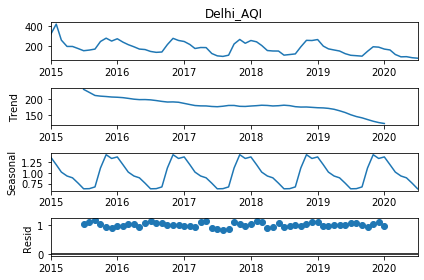

In [248]:
from statsmodels.tsa.seasonal import seasonal_decompose
Delhi_AQI=final_df['Delhi_AQI']
result=seasonal_decompose(Delhi_AQI,model='multiplicative')
result.plot();
Delhi_AQI

In [249]:
# Forecasting: 
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima; 

In [250]:
auto_arima(y=Delhi_AQI,start_p=0,start_P=0,start_q=0,start_Q=0,seasonal=True, m=12)

ARIMA(order=(0, 1, 2), scoring_args={}, seasonal_order=(1, 0, 1, 12),
      with_intercept=False)

In [251]:
#dividing into train and test:
train=Delhi_AQI[:41] #from 2015-2018
test=Delhi_AQI[42:54]# june-july 2019

In [252]:
# Forming the model:
model=SARIMAX(train,order=(1,1,1),seasonal_order=(1,0,1,12),)
results=model.fit()

In [253]:
#predicted values:
predictions = results.predict(start=42, end=53, typ='levels').rename('Predictions')

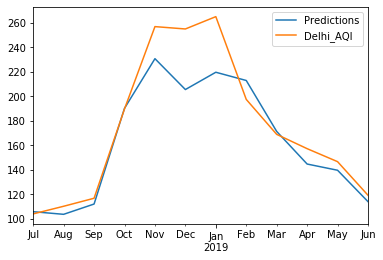

In [254]:
#Plotting predicted values with the true values:
predictions.plot(legend=True)
test.plot(legend=True);

In [255]:
from sklearn.metrics import mean_squared_error
RMSE=np.sqrt(mean_squared_error(predictions,test))
print('RMSE = ',RMSE)
print('Mean AQI',test.mean())

RMSE =  21.86369706160075
Mean AQI 173.89252879752266


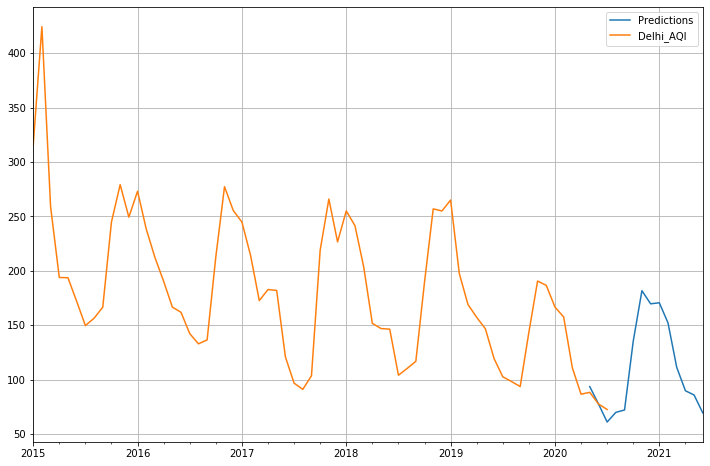

In [256]:
# Forming the model:
model=SARIMAX(Delhi_AQI,order=(1,1,1),seasonal_order=(1,0,1,12))
results=model.fit()
results.summary()
#Obtaining predicted values:
predictions = results.predict(start=64, end=77, typ='levels').rename('Predictions')
#Plotting predicted values against the true values:
predictions.plot(legend=True)
Delhi_AQI.plot(legend=True,figsize=(12,8),grid=True);

## Deep Leaning Model

In [257]:
Delhi_AQI=Delhi_AQI.reset_index()
Delhi_AQI.columns=['ds','y']
Delhi_AQI=Delhi_AQI.set_index('ds')
train=Delhi_AQI[:-24]
test=Delhi_AQI[-24:-12]
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

### Formatting the data:

In [258]:
from keras.preprocessing.sequence import TimeseriesGenerator
n_input = 24
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [259]:
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.67292602 1.         0.50372626 0.30852832 0.30774907 0.24262397
 0.17586106 0.19605334 0.22674095 0.46158029 0.56459079 0.47485447
 0.54636138 0.44194753 0.36353688 0.29791689 0.22695264 0.21239967
 0.15379372 0.12557582 0.13633343 0.36540978 0.55883594 0.49338753]
Predict this y: 
 [[0.46141368]]


In [260]:
### Creating the model:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
# defining the model(note that  I am using a very basic model here, a 2 layer model only):
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 50)                10400     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


### Fitting the model:


In [ ]:
# Fitting the model with the generator object:
model.fit_generator(generator,epochs=250)

Epoch 1/250
19/19 [==============================] - 0s 6ms/step - loss: 0.0569
Epoch 2/250
19/19 [==============================] - 0s 5ms/step - loss: 0.0323
Epoch 3/250
19/19 [==============================] - 0s 5ms/step - loss: 0.0337
Epoch 4/250
19/19 [==============================] - 0s 6ms/step - loss: 0.0301
Epoch 5/250
19/19 [==============================] - 0s 5ms/step - loss: 0.0277
Epoch 6/250
19/19 [==============================] - 0s 5ms/step - loss: 0.0278
Epoch 7/250
19/19 [==============================] - 0s 5ms/step - loss: 0.0271
Epoch 8/250
19/19 [==============================] - 0s 5ms/step - loss: 0.0288
Epoch 9/250
19/19 [==============================] - 0s 5ms/step - loss: 0.0268
Epoch 10/250
19/19 [==============================] - 0s 5ms/step - loss: 0.0272
Epoch 11/250
19/19 [==============================] - 0s 5ms/step - loss: 0.0256
Epoch 12/250
19/19 [==============================] - 0s 6ms/step - loss: 0.0248
Epoch 13/250
19/19 [=================

In [ ]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    
    current_pred = model.predict(current_batch)[0]
    
    
    test_predictions.append(current_pred) 
    
    
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [ ]:
true_predictions = scaler.inverse_transform(test_predictions)
test['Predictions'] = true_predictions
test.plot(figsize=(12,8))
plt.plot(true_predictions)


In [ ]:
RMSE=np.sqrt(mean_squared_error(test['y'],test['Predictions']))
print('RMSE = ',RMSE)
print('Delhi_AQI=',Delhi_AQI['y'].mean())